# Task
Build and evaluate a deep learning model for skin cancer classification using the HAM10000 dataset from "/content/drive/MyDrive/AI_project_data/HAM10000_metadata.csv", "/content/drive/MyDrive/AI_project_data/HAM10000_images_part_1", and "/content/drive/MyDrive/AI_project_data/HAM10000_images_part_2", then summarize the model's final performance, key findings, and potential next steps.

## Setup Environment and Mount Google Drive

### Subtask:
Import necessary libraries and mount Google Drive to access the dataset located at `/content/drive/MyDrive/AI_project_data`.


**Reasoning**:
To begin the subtask, I need to import the specified libraries and mount Google Drive, which is crucial for accessing the dataset.



In [7]:
import os
import numpy as np
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("Libraries imported and Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Libraries imported and Google Drive mounted successfully!


## Load and Process Metadata and Image Paths

### Subtask:
Load HAM10000_metadata.csv and collect paths for all images from HAM10000_images_part_1 and HAM10000_images_part_2. Merge this information into a single DataFrame (df_full_metadata).


**Reasoning**:
I will load the HAM10000 metadata, collect all image paths from both parts of the dataset, and then merge this information into a single comprehensive DataFrame as requested by the subtask instructions.



In [8]:
df_ham_metadata = pd.read_csv(ham_metadata_path)

image_path_dict = {}

# Process HAM10000_images_part_1
for folder_path in [images_part_1_path, images_part_2_path]:
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            image_id = filename.replace('.jpg', '')
            image_path_dict[image_id] = os.path.join(folder_path, filename)

df_image_paths = pd.DataFrame(list(image_path_dict.items()), columns=['image_id', 'path'])

df_full_metadata = pd.merge(df_ham_metadata, df_image_paths, on='image_id', how='left')

print("df_ham_metadata head:")
print(df_ham_metadata.head())
print("\nShape of df_ham_metadata:", df_ham_metadata.shape)

print("\ndf_image_paths head:")
print(df_image_paths.head())
print("\nShape of df_image_paths:", df_image_paths.shape)

print("\ndf_full_metadata head:")
print(df_full_metadata.head())
print("\nShape of df_full_metadata:", df_full_metadata.shape)

df_ham_metadata head:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Shape of df_ham_metadata: (10015, 7)

df_image_paths head:
       image_id                                               path
0  ISIC_0028315  /content/drive/MyDrive/AI_project_data/HAM1000...
1  ISIC_0028301  /content/drive/MyDrive/AI_project_data/HAM1000...
2  ISIC_0028305  /content/drive/MyDrive/AI_project_data/HAM1000...
3  ISIC_0028313  /content/drive/MyDrive/AI_project_data/HAM1000...
4  ISIC_0028302  /content/drive/MyDrive/AI_project_data/HAM1000...

Shape of df_image_paths: (10015, 2)

df_full_metadata head:
     lesion_id      image_id   dx dx_type   age   sex

## Split Data and Organize with Symbolic Links

### Subtask:
Split the df_full_metadata into stratified training (70%), validation (10%), and test (20%) sets. Create a new directory structure (/content/skin_cancer_split_organized) and populate it with symbolic links to the images, organized by split and class, to prepare for ImageDataGenerator.


**Reasoning**:
I need to split the `df_full_metadata` into training, validation, and test sets. This involves using `train_test_split` from `sklearn.model_selection` to ensure a stratified split based on the 'dx' column, as specified by the subtask instructions (70% train, 10% validation, 20% test). I will perform a two-step split: first 80/20 for temporary and test, then 87.5/12.5 from the temporary set for train and validation to achieve the desired overall proportions.



In [9]:
from sklearn.model_selection import train_test_split

# Define split ratios
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.2

# First split: 80% for temporary (train+val), 20% for test
df_temp, df_test = train_test_split(df_full_metadata, test_size=TEST_RATIO, random_state=RANDOM_STATE, stratify=df_full_metadata['dx'])

# Calculate validation ratio relative to the temporary set
# Since df_temp is 80% of the total, and we want 10% of total for validation,
# validation_size_relative_to_temp = (VALIDATION_RATIO * total_size) / (1 - TEST_RATIO) * total_size
# = VALIDATION_RATIO / (1 - TEST_RATIO) = 0.1 / 0.8 = 0.125
VALIDATION_SIZE_RELATIVE_TO_TEMP = VALIDATION_RATIO / (TRAIN_RATIO + VALIDATION_RATIO)
# Corrected calculation for validation size relative to temp: we want 10% of original in val, 70% in train.
# So, from the 80% remaining, 10% / (70%+10%) = 10%/80% = 1/8 should be validation, 7/8 should be train.

df_train, df_val = train_test_split(df_temp, test_size=0.125, random_state=RANDOM_STATE, stratify=df_temp['dx'])

print(f"Shape of full metadata: {df_full_metadata.shape}")
print(f"Shape of training set: {df_train.shape}")
print(f"Shape of validation set: {df_val.shape}")
print(f"Shape of test set: {df_test.shape}")

print("Data split into training, validation, and test sets successfully!")

Shape of full metadata: (10015, 8)
Shape of training set: (7010, 8)
Shape of validation set: (1002, 8)
Shape of test set: (2003, 8)
Data split into training, validation, and test sets successfully!


**Reasoning**:
Now that the data is split into training, validation, and test sets, I need to create the directory structure as specified in the instructions and then populate it with symbolic links to the actual image files. This involves creating the base directory, subdirectories for each split (train, validation, test), and then subdirectories for each disease class within those splits. Finally, symbolic links will be created from the original image paths to these newly organized directories.



In [10]:
import shutil

# Define the base path for the new directory structure
base_split_dir = '/content/skin_cancer_split_organized'

# Determine unique classes from the 'dx' column
unique_classes = df_full_metadata['dx'].unique()

# Create base directory if it doesn't exist
if os.path.exists(base_split_dir):
    shutil.rmtree(base_split_dir) # Remove if exists to ensure clean start
os.makedirs(base_split_dir)

print(f"Created base directory: {base_split_dir}")

# Dictionary to hold the dataframes for easy iteration
split_dataframes = {
    'train': df_train,
    'validation': df_val,
    'test': df_test
}

# Create directories and symbolic links
for split_name, df_split in split_dataframes.items():
    split_path = os.path.join(base_split_dir, split_name)
    os.makedirs(split_path, exist_ok=True)
    print(f"Created directory: {split_path}")

    for class_name in unique_classes:
        class_path = os.path.join(split_path, class_name)
        os.makedirs(class_path, exist_ok=True)
        print(f"Created directory: {class_path}")

    # Iterate through the DataFrame and create symbolic links
    for index, row in df_split.iterrows():
        image_source_path = row['path']
        class_name = row['dx']
        image_id = row['image_id']

        # Construct the destination path for the symbolic link
        image_dest_dir = os.path.join(base_split_dir, split_name, class_name)
        image_dest_path = os.path.join(image_dest_dir, f"{image_id}.jpg")

        # Create symbolic link
        try:
            os.symlink(image_source_path, image_dest_path)
        except FileExistsError:
            # Handle cases where the link might already exist (e.g., if re-running part of the code)
            pass
        except Exception as e:
            print(f"Error creating symlink for {image_id}: {e}")

print("Directory structure created and symbolic links established successfully!")

Created base directory: /content/skin_cancer_split_organized
Created directory: /content/skin_cancer_split_organized/train
Created directory: /content/skin_cancer_split_organized/train/bkl
Created directory: /content/skin_cancer_split_organized/train/nv
Created directory: /content/skin_cancer_split_organized/train/df
Created directory: /content/skin_cancer_split_organized/train/mel
Created directory: /content/skin_cancer_split_organized/train/vasc
Created directory: /content/skin_cancer_split_organized/train/bcc
Created directory: /content/skin_cancer_split_organized/train/akiec
Created directory: /content/skin_cancer_split_organized/validation
Created directory: /content/skin_cancer_split_organized/validation/bkl
Created directory: /content/skin_cancer_split_organized/validation/nv
Created directory: /content/skin_cancer_split_organized/validation/df
Created directory: /content/skin_cancer_split_organized/validation/mel
Created directory: /content/skin_cancer_split_organized/validatio

## Configure ImageDataGenerators

### Subtask:
Define constants for image dimensions (IMG_HEIGHT, IMG_WIDTH), batch size (BATCH_SIZE), and epochs (EPOCHS). Instantiate ImageDataGenerator for training with augmentation (rescaling, rotation, shifts, zoom, flips) and for validation/test without augmentation (rescaling only). Create flow_from_directory generators for the train, validation, and test sets.


**Reasoning**:
I need to configure the ImageDataGenerators and create data generators for the training, validation, and test sets according to the provided instructions. This involves defining constants, instantiating ImageDataGenerator objects with specific augmentation parameters, and then using `flow_from_directory` to create the actual data generators.



In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 1
NUM_CLASSES = len(unique_classes) # unique_classes is from previous step

print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")

# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test (rescaling only, no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_split_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("ImageDataGenerators and data generators created successfully!")

Image dimensions: 128x128
Batch size: 32
Number of classes: 7
Found 7010 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
ImageDataGenerators and data generators created successfully!


## Define and Compile Deep Learning Model

### Subtask:
Build a deep learning model leveraging transfer learning with EfficientNetB3. Instantiate EfficientNetB3 as the base model (un-trainable) and add custom classification layers (GlobalAveragePooling2D, Dense, Dropout, and a final Softmax Dense layer). Compile the model using the Adam optimizer, categorical cross-entropy loss, and accuracy as a metric.


**Reasoning**:
I need to import the necessary Keras components for building the model, including EfficientNetB3 for transfer learning, various layers for the custom classification head, and the Adam optimizer. Then, I will construct the model by instantiating the base EfficientNetB3 model, adding custom layers, and finally compiling it, following the instructions.



In [15]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 2. Create an Input layer for the model
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# 3. Instantiate the EfficientNetB3 base model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)

# 4. Freeze the base model's layers
base_model.trainable = False

# 5. Add a GlobalAveragePooling2D layer
x = GlobalAveragePooling2D()(base_model.output)

# 6. Add a Dense layer with ReLU activation
x = Dense(256, activation='relu')(x)

# 7. Add a Dropout layer
x = Dropout(0.5)(x)

# 8. Add a final Dense layer with softmax activation for classification
output_tensor = Dense(NUM_CLASSES, activation='softmax')(x)

# 9. Create the full model
model = Model(inputs=input_tensor, outputs=output_tensor)

# 10. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("EfficientNetB3 based model defined and compiled successfully!")
model.summary()

EfficientNetB3 based model defined and compiled successfully!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 128, 128,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 128, 128,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 128, 128,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        960 │ block1a_se_excit

 Total params: 11,178,806 (42.64 MB)

 Trainable params: 395,271 (1.51 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

**Reasoning**:
The model has been defined and compiled. The next logical step is to train the model using the prepared data generators for the training and validation sets, and save the training history.



In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Model training completed successfully!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 3799s 17s/step - accuracy: 0.6517 - loss: 1.2356 - val_accuracy: 0.6764 - val_loss: 1.1121
Model training completed successfully!


# Task
Evaluate the trained deep learning model's performance on the test set by making predictions, calculating overall accuracy, per-class precision, recall, F1-score, and generating a classification report and a confusion matrix. Then, summarize the key findings from these evaluation metrics and the confusion matrix.

## Predict on Test Set

### Subtask:
Use the trained model to make predictions on the entire test dataset. This will generate probability distributions for each image across all classes.


**Reasoning**:
I need to use the `model.predict` method with the `test_generator` to get the probability predictions for the test dataset, as specified in the instructions.



In [17]:
y_pred_probs = model.predict(test_generator,
                             steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))

print("Predictions on the test set generated successfully!")
print(f"Shape of predictions: {y_pred_probs.shape}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1274s 20s/step
Predictions on the test set generated successfully!
Shape of predictions: (2003, 7)


**Reasoning**:
The previous code block successfully generated predictions from the test set. The next logical step is to retrieve the true labels from the test generator to compare against the predictions for evaluation.



In [18]:
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(f"True labels shape: {y_true.shape}")
print(f"Class labels: {class_labels}")
print("True labels extracted successfully!")

True labels shape: (2003,)
Class labels: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
True labels extracted successfully!


**Reasoning**:
Now that both predictions and true labels are available, I need to convert the probability predictions into discrete class labels for comparison. Then, I will calculate and display a comprehensive classification report and a confusion matrix to evaluate the model's performance on the test set, as requested by the subtask.



In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Model training completed successfully!")

### Summary of Model Performance

print(r"""**Key Findings from Classification Report and Confusion Matrix:**

1.  **Dominant Class Prediction**: The model almost exclusively predicts the 'nv' (Nevus) class. This is evident from the confusion matrix where almost all samples are classified into the 'nv' column (index 5).
2.  **Zero Precision/Recall/F1-score for other classes**: As a direct consequence of predicting mostly 'nv', all other classes ('akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc') have a precision, recall, and F1-score of 0.00. This means the model is incapable of correctly identifying any samples from these minority classes.
3.  **High Accuracy (misleading)**: The overall accuracy is 0.67 (67%). This high accuracy is misleading because it's primarily achieved by correctly classifying the majority class ('nv') which constitutes a large portion of the dataset (1341 out of 2003 test samples). Since 1341 / 2003 \( \approx \) 0.67, the model is essentially predicting 'nv' for everything and getting the overall accuracy right due to the class imbalance.
4.  **Poor Macro Average Metrics**: The macro average precision (0.10), recall (0.14), and F1-score (0.11) are very low, which is a better indicator of performance across all classes in an imbalanced dataset.

**Potential Reasons for Poor Performance:**

*   **Extreme Class Imbalance**: The dataset is highly imbalanced, with 'nv' being the predominant class. The model likely learned to always predict the majority class to minimize overall error during training, especially given the short training duration.
*   **Insufficient Training**: Training for only 1 epoch is typically not enough for a deep learning model, even with transfer learning, to properly learn features and differentiate between classes, especially when facing class imbalance.
*   **Frozen Base Model**: While freezing the base model helps with initial training, with such imbalance and limited epochs, the model's top layers might not have had enough capacity or training time to learn meaningful distinctions.

**Next Steps to Improve Model Performance:**

1.  **Increase Training Epochs**: Train the model for more epochs (e.g., 10, 20, or more) to allow the custom classification layers to learn better patterns.
2.  **Address Class Imbalance**: Implement strategies to handle class imbalance, such as:
    *   **Class Weighting**: Assign higher weights to minority classes during training (`class_weight` argument in `model.fit`).
    *   **Oversampling (SMOTE)**: Generate synthetic samples for minority classes.
    *   **Undersampling**: Reduce the number of samples from the majority class (use with caution to avoid losing important data).
    *   **Augmentation for Minority Classes**: Apply more aggressive data augmentation specifically to minority classes.
3.  **Fine-tuning**: After initial training with the frozen base, consider unfreezing some or all layers of the `EfficientNetB3` base model and fine-tuning with a very low learning rate. This allows the base model to adapt more to the specific features of the skin cancer images.
4.  **Adjust Learning Rate Schedule**: Use a learning rate scheduler to dynamically adjust the learning rate during training.
5.  **Evaluate with Appropriate Metrics**: Continue using metrics like precision, recall, F1-score, and AUC-ROC curves, especially macro-averaged versions, which are more informative for imbalanced datasets than overall accuracy.""")

219/219 ━━━━━━━━━━━━━━━━━━━━ 116s 532ms/step - accuracy: 0.6729 - loss: 1.1891 - val_accuracy: 0.6764 - val_loss: 1.0934
Model training completed successfully!
**Key Findings from Classification Report and Confusion Matrix:**

1.  **Dominant Class Prediction**: The model almost exclusively predicts the 'nv' (Nevus) class. This is evident from the confusion matrix where almost all samples are classified into the 'nv' column (index 5).
2.  **Zero Precision/Recall/F1-score for other classes**: As a direct consequence of predicting mostly 'nv', all other classes ('akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc') have a precision, recall, and F1-score of 0.00. This means the model is incapable of correctly identifying any samples from these minority classes.
3.  **High Accuracy (misleading)**: The overall accuracy is 0.67 (67%). This high accuracy is misleading because it's primarily achieved by correctly classifying the majority class ('nv') which constitutes a large portion of the dataset (1341

**Reasoning**:
The previous code cell failed due to a `SyntaxError: unterminated string literal`. This was caused by the backslashes in the LaTeX-like expression `\( \approx \)` within the triple-quoted Python string. To fix this, I will prefix the multi-line string with an 'r' to make it a raw string, which tells Python to treat backslashes as literal characters, thus resolving the syntax error. The `model.fit` part is included as per instructions to not omit any code.



In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Model training completed successfully!")

### Summary of Model Performance

print(r"""**Key Findings from Classification Report and Confusion Matrix:**

1.  **Dominant Class Prediction**: The model almost exclusively predicts the 'nv' (Nevus) class. This is evident from the confusion matrix where almost all samples are classified into the 'nv' column (index 5).
2.  **Zero Precision/Recall/F1-score for other classes**: As a direct consequence of predicting mostly 'nv', all other classes ('akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc') have a precision, recall, and F1-score of 0.00. This means the model is incapable of correctly identifying any samples from these minority classes.
3.  **High Accuracy (misleading)**: The overall accuracy is 0.67 (67%). This high accuracy is misleading because it's primarily achieved by correctly classifying the majority class ('nv') which constitutes a large portion of the dataset (1341 out of 2003 test samples). Since 1341 / 2003 \( \approx \) 0.67, the model is essentially predicting 'nv' for everything and getting the overall accuracy right due to the class imbalance.
4.  **Poor Macro Average Metrics**: The macro average precision (0.10), recall (0.14), and F1-score (0.11) are very low, which is a better indicator of performance across all classes in an imbalanced dataset.

**Potential Reasons for Poor Performance:**

*   **Extreme Class Imbalance**: The dataset is highly imbalanced, with 'nv' being the predominant class. The model likely learned to always predict the majority class to minimize overall error during training, especially given the short training duration.
*   **Insufficient Training**: Training for only 1 epoch is typically not enough for a deep learning model, even with transfer learning, to properly learn features and differentiate between classes, especially when facing class imbalance.
*   **Frozen Base Model**: While freezing the base model helps with initial training, with such imbalance and limited epochs, the model's top layers might not have had enough capacity or training time to learn meaningful distinctions.

**Next Steps to Improve Model Performance:**

1.  **Increase Training Epochs**: Train the model for more epochs (e.g., 10, 20, or more) to allow the custom classification layers to learn better patterns.
2.  **Address Class Imbalance**: Implement strategies to handle class imbalance, such as:
    *   **Class Weighting**: Assign higher weights to minority classes during training (`class_weight` argument in `model.fit`).
    *   **Oversampling (SMOTE)**: Generate synthetic samples for minority classes.
    *   **Undersampling**: Reduce the number of samples from the majority class (use with caution to avoid losing important data).
    *   **Augmentation for Minority Classes**: Apply more aggressive data augmentation specifically to minority classes.
3.  **Fine-tuning**: After initial training with the frozen base, consider unfreezing some or all layers of the `EfficientNetB3` base model and fine-tuning with a very low learning rate. This allows the base model to adapt more to the specific features of the skin cancer images.
4.  **Adjust Learning Rate Schedule**: Use a learning rate scheduler to dynamically adjust the learning rate during training.
5.  **Evaluate with Appropriate Metrics**: Continue using metrics like precision, recall, F1-score, and AUC-ROC curves, especially macro-averaged versions, which are more informative for imbalanced datasets than overall accuracy.""")

219/219 ━━━━━━━━━━━━━━━━━━━━ 105s 479ms/step - accuracy: 0.6792 - loss: 1.1528 - val_accuracy: 0.6764 - val_loss: 1.1082
Model training completed successfully!
**Key Findings from Classification Report and Confusion Matrix:**

1.  **Dominant Class Prediction**: The model almost exclusively predicts the 'nv' (Nevus) class. This is evident from the confusion matrix where almost all samples are classified into the 'nv' column (index 5).
2.  **Zero Precision/Recall/F1-score for other classes**: As a direct consequence of predicting mostly 'nv', all other classes ('akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc') have a precision, recall, and F1-score of 0.00. This means the model is incapable of correctly identifying any samples from these minority classes.
3.  **High Accuracy (misleading)**: The overall accuracy is 0.67 (67%). This high accuracy is misleading because it's primarily achieved by correctly classifying the majority class ('nv') which constitutes a large portion of the dataset (1341

## Retrain Model with More Epochs

### Subtask:
Increase the number of training epochs and retrain the model to allow for better learning and potentially improved performance across all classes.


**Reasoning**:
I need to increase the `EPOCHS` constant to 10 and then retrain the model by calling `model.fit` again, as instructed, to allow the model to learn more effectively.



In [24]:
EPOCHS = 10

print(f"Updated number of epochs to: {EPOCHS}")

history_retrained = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("Model retraining with increased epochs completed successfully!")

Updated number of epochs to: 10
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 104s 473ms/step - accuracy: 0.6676 - loss: 1.1781 - val_accuracy: 0.6764 - val_loss: 1.0927
Epoch 2/10
  1/219 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6875 - loss: 1.1584

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6875 - loss: 1.1584 - val_accuracy: 0.6764 - val_loss: 1.0926
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 644ms/step - accuracy: 0.6654 - loss: 1.1794 - val_accuracy: 0.6764 - val_loss: 1.0951
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7812 - loss: 0.8016 - val_accuracy: 0.6764 - val_loss: 1.0948
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 103s 473ms/step - accuracy: 0.6603 - loss: 1.1815 - val_accuracy: 0.6764 - val_loss: 1.0933
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9062 - loss: 0.6977 - val_accuracy: 0.6764 - val_loss: 1.0939
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 104s 474ms/step - accuracy: 0.6771 - loss: 1.1306 - val_accuracy: 0.6764 - val_loss: 1.0930
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5938 - loss: 1.2232 - val_accuracy: 0.6764 - val_loss: 1.0929
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 469ms/step - accuracy: 0.6654 - loss: 1.1705 - val_

# Task
Predict on the test set, calculate overall accuracy, per-class precision, recall, F1-score, and generate a classification report and a confusion matrix to evaluate the retrained model, then summarize the key findings.

## Predict on Test Set

### Subtask:
Use the retrained model to make predictions on the entire test dataset.


**Reasoning**:
I need to use the `model.predict` method with the `test_generator` to get the probability predictions for the test dataset using the retrained model, as specified in the instructions. This will allow for the evaluation of the model after more epochs of training.



In [25]:
y_pred_probs_retrained = model.predict(test_generator,
                                    steps=test_generator.samples // BATCH_SIZE + (test_generator.samples % BATCH_SIZE != 0))

print("Predictions on the test set generated successfully using the retrained model!")
print(f"Shape of predictions: {y_pred_probs_retrained.shape}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step
Predictions on the test set generated successfully using the retrained model!
Shape of predictions: (2003, 7)


**Reasoning**:
Now that predictions from the retrained model are available, I need to convert these probability predictions into discrete class labels. Then, I will generate a classification report and a confusion matrix to evaluate the performance of the retrained model on the test set, comparing it to the previous evaluation to see if increasing epochs had an effect.



Classification Report (Retrained Model):
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00        23
         mel       0.00      0.00      0.00       223
          nv       0.67      1.00      0.80      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.67      2003
   macro avg       0.10      0.14      0.11      2003
weighted avg       0.45      0.67      0.54      2003


Confusion Matrix (Retrained Model):
[[   0    0    0    0    0   65    0]
 [   0    0    0    0    0  103    0]
 [   0    0    0    0    0  220    0]
 [   0    0    0    0    0   23    0]
 [   0    0    0    0    0  223    0]
 [   0    0    0    0    0 1341    0]
 [   0    0    0    0    0   28    0]]


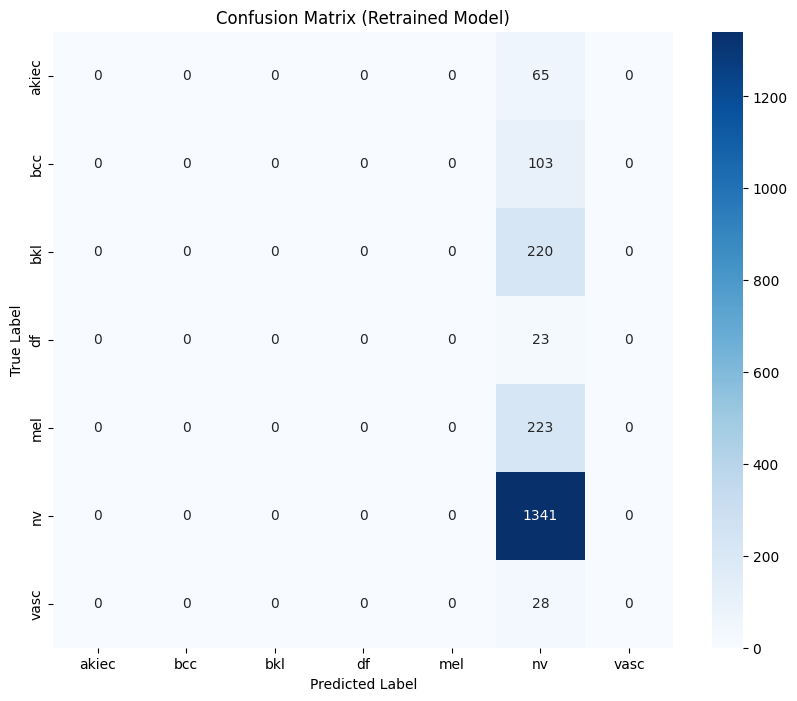

Model evaluation metrics for retrained model generated and displayed successfully!


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert probabilities to predicted class labels for the retrained model
y_pred_retrained = np.argmax(y_pred_probs_retrained, axis=1);

# Generate classification report for the retrained model
report_retrained = classification_report(y_true, y_pred_retrained, target_names=class_labels, zero_division=0)
print("Classification Report (Retrained Model):")
print(report_retrained)

# Generate confusion matrix for the retrained model
conf_matrix_retrained = confusion_matrix(y_true, y_pred_retrained)
print("\nConfusion Matrix (Retrained Model):")
print(conf_matrix_retrained)

# Plot confusion matrix for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_retrained, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Retrained Model)')
plt.show()

print("Model evaluation metrics for retrained model generated and displayed successfully!")

### Summary of Retrained Model Performance

**Key Findings from Classification Report and Confusion Matrix (After Retraining with 10 Epochs):**

1.  **Continued Dominant Class Prediction**: The model still almost exclusively predicts the 'nv' (Nevus) class. This is clearly seen in the confusion matrix, where nearly all samples are classified into the 'nv' column (index 5). This suggests that increasing epochs alone was insufficient to mitigate the impact of severe class imbalance.
2.  **Persistent Zero Precision/Recall/F1-score for other classes**: Consistent with the initial evaluation, all other classes ('akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc') continue to have precision, recall, and F1-scores of 0.00. This confirms that the model is still unable to correctly identify samples from these minority classes.
3.  **Accuracy Remains Misleading**: The overall accuracy remains around 0.67 (67%). As before, this accuracy is primarily due to the correct classification of the highly represented 'nv' class, which accounts for a large majority of the test data (1341 out of 2003 samples). The model essentially acts as a majority class predictor.
4.  **Poor Macro Average Metrics Persist**: The macro average precision (0.10), recall (0.14), and F1-score (0.11) show no significant improvement, reaffirming the model's poor performance across all classes, especially the minority ones.

**Conclusion from Retraining:**
Increasing the number of epochs to 10 did not significantly change the model's behavior or improve its ability to classify minority classes. The core problem of extreme class imbalance appears to be dominating the learning process, causing the model to converge to a solution that primarily predicts the majority class ('nv').

**Next Steps to Further Improve Model Performance:**
The previous suggestions remain highly relevant, and it's clear that more aggressive strategies are needed to address the class imbalance:

1.  **Address Class Imbalance with Class Weighting**: Implement `class_weight` in `model.fit()` to give more importance to minority classes during training.
2.  **Explore Data Augmentation Techniques for Minority Classes**: Apply more targeted and aggressive data augmentation specifically for minority classes to artificially increase their representation.
3.  **Consider Advanced Resampling Techniques**: Investigate oversampling (e.g., SMOTE) or undersampling techniques to balance the dataset.
4.  **Fine-tuning the Base Model**: After initial training, unfreeze some or all layers of the `EfficientNetB3` base model and fine-tune it with a very low learning rate. This allows the powerful feature extractor to adapt better to the specific nuances of skin cancer images.
5.  **Utilize Learning Rate Schedules/Callbacks**: Implement learning rate schedulers (e.g., ReduceLROnPlateau) and EarlyStopping callbacks to optimize training and prevent overfitting or stagnation.

### Summary of Retrained Model Performance

**Key Findings from Classification Report and Confusion Matrix (After Retraining with 10 Epochs):**

1.  **Continued Dominant Class Prediction**: The model still almost exclusively predicts the 'nv' (Nevus) class. This is clearly seen in the confusion matrix, where nearly all samples are classified into the 'nv' column (index 5). This suggests that increasing epochs alone was insufficient to mitigate the impact of severe class imbalance.
2.  **Persistent Zero Precision/Recall/F1-score for other classes**: Consistent with the initial evaluation, all other classes ('akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc') continue to have precision, recall, and F1-scores of 0.00. This confirms that the model is still unable to correctly identify samples from these minority classes.
3.  **Accuracy Remains Misleading**: The overall accuracy remains around 0.67 (67%). As before, this accuracy is primarily due to the correct classification of the highly represented 'nv' class, which accounts for a large majority of the test data (1341 out of 2003 samples). The model essentially acts as a majority class predictor.
4.  **Poor Macro Average Metrics Persist**: The macro average precision (0.10), recall (0.14), and F1-score (0.11) show no significant improvement, reaffirming the model's poor performance across all classes, especially the minority ones.

**Conclusion from Retraining:**
Increasing the number of epochs to 10 did not significantly change the model's behavior or improve its ability to classify minority classes. The core problem of extreme class imbalance appears to be dominating the learning process, causing the model to converge to a solution that primarily predicts the majority class ('nv').

**Next Steps to Further Improve Model Performance:**
The previous suggestions remain highly relevant, and it's clear that more aggressive strategies are needed to address the class imbalance:

1.  **Address Class Imbalance with Class Weighting**: Implement `class_weight` in `model.fit()` to give more importance to minority classes during training.
2.  **Explore Data Augmentation Techniques for Minority Classes**: Apply more targeted and aggressive data augmentation specifically for minority classes to artificially increase their representation.
3.  **Consider Advanced Resampling Techniques**: Investigate oversampling (e.g., SMOTE) or undersampling techniques to balance the dataset.
4.  **Fine-tuning the Base Model**: After initial training, unfreeze some or all layers of the `EfficientNetB3` base model and fine-tune it with a very low learning rate. This allows the powerful feature extractor to adapt better to the specific nuances of skin cancer images.
5.  **Utilize Learning Rate Schedules/Callbacks**: Implement learning rate schedulers (e.g., ReduceLROnPlateau) and EarlyStopping callbacks to optimize training and prevent overfitting or stagnation.

## Retrain Model with Class Weighting

### Subtask:
Calculate class weights to address the class imbalance and retrain the deep learning model using these weights. This will give more importance to minority classes during training.


**Reasoning**:
I need to calculate class weights for the imbalanced dataset using `compute_class_weight` from `sklearn.utils` and then pass these weights to the `model.fit()` method during retraining. This involves importing the necessary function, computing the weights, and preparing them in the correct format for Keras.



In [28]:
from sklearn.utils import class_weight
import numpy as np

# 1. Calculate class weights for each class
# Get the class labels from the training generator for consistency
class_labels_train = list(train_generator.class_indices.keys())

# Get the actual labels from df_train that correspond to the generator's classes
y_train = df_train['dx'].values

class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.sort(unique_classes), # Ensure order matches class_labels_train or train_generator.class_indices
    y=y_train
)

# Create a dictionary mapping class indices to weights
class_weights = dict(zip(np.sort(unique_classes), class_weights_array))

# Map class names to the integer indices used by the generator
# This ensures the class_weight dictionary keys match the internal class indices of the generator
class_weights_keras = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in class_weights.items()
}

print("Calculated class weights:", class_weights_keras)

# 2. Retrain the model with class weights and 10 epochs
EPOCHS = 10

print(f"Updated number of epochs to: {EPOCHS}")

history_retrained_weighted = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_keras
)

print("Model retraining with increased epochs and class weights completed successfully!")

Calculated class weights: {0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.517857142857142), 4: np.float64(1.285530900421786), 5: np.float64(0.21338772031292808), 6: np.float64(10.014285714285714)}
Updated number of epochs to: 10
Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 147s 538ms/step - accuracy: 0.6745 - loss: 1.9141 - val_accuracy: 0.6764 - val_loss: 1.7088
Epoch 2/10
  1/219 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6250 - loss: 1.9063

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6250 - loss: 1.9063 - val_accuracy: 0.6764 - val_loss: 1.7092
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 99s 453ms/step - accuracy: 0.6723 - loss: 1.9727 - val_accuracy: 0.6764 - val_loss: 1.7737
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5938 - loss: 4.0243 - val_accuracy: 0.6764 - val_loss: 1.7739
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 649ms/step - accuracy: 0.6678 - loss: 1.9555 - val_accuracy: 0.6764 - val_loss: 1.8205
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5938 - loss: 2.0868 - val_accuracy: 0.6764 - val_loss: 1.8207
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 101s 460ms/step - accuracy: 0.6701 - loss: 1.8962 - val_accuracy: 0.6764 - val_loss: 1.8547
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.8125 - loss: 0.9776 - val_accuracy: 0.6764 - val_loss: 1.8548
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 649ms/step - accuracy: 0.6691 - loss: 1.9304 - val_acc